In [15]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler



In [16]:
df = pd.read_csv('data/Traffic.csv')
df

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal
...,...,...,...,...,...,...,...,...,...
2971,10:45:00 PM,9,Thursday,16,3,1,36,56,normal
2972,11:00:00 PM,9,Thursday,11,0,1,30,42,normal
2973,11:15:00 PM,9,Thursday,15,4,1,25,45,normal
2974,11:30:00 PM,9,Thursday,16,5,0,27,48,normal


In [17]:
df.shape
#Get date range
print('Start date:', df['Date'].min())
print('End date:', df['Date'].max())



Start date: 1
End date: 31


In [18]:
import pandas as pd
import numpy as np

# Convert 'Time' to datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p').dt.time

# Encode hours as sine and cosine
df['hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df.drop(columns=['Time', 'hour'], inplace=True)  # Drop original 'Time' column


In [19]:
df = pd.get_dummies(df, columns=['Day of the week'], drop_first=True)

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Traffic Situation'] = label_encoder.fit_transform(df['Traffic Situation'])
df = pd.get_dummies(df, columns=['Traffic Situation'], drop_first=True)



In [21]:
lags = 3  # Number of lag steps to include
for i in range(1, lags + 1):
    df[f'Total_lag_{i}'] = df['Total'].shift(i)

df.dropna(inplace=True)  # Drop rows with NaN values created by lagging



In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical_features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total'] + \
                     [f'Total_lag_{i}' for i in range(1, lags + 1)] + \
                     ['hour_sin', 'hour_cos']
df[numerical_features] = scaler.fit_transform(df[numerical_features])




In [23]:
X = df.drop(columns=['Total']).values
y = df['Total'].values




In [24]:
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])  # Sequence of time_steps
        y_seq.append(y[i + time_steps])  # Target is the next step
    return np.array(X_seq), np.array(y_seq)

time_steps = 10
X_seq, y_seq = create_sequences(X, y, time_steps)



In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)






In [26]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


In [68]:
from tensorflow.keras.layers import Bidirectional, LeakyReLU, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
model2 = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    LeakyReLU(alpha=0.01),
    Dropout(0.4),
    Bidirectional(LSTM(128, return_sequences=False)), 
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1)
])

model2.compile(optimizer='adam', loss='mse', metrics=['mae'])



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [69]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0567 - mae: 0.1933 - val_loss: 0.0302 - val_mae: 0.1448 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0257 - mae: 0.1272 - val_loss: 0.0171 - val_mae: 0.0987 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0190 - mae: 0.1065 - val_loss: 0.0179 - val_mae: 0.0997 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0195 - mae: 0.1058 - val_loss: 0.0174 - val_mae: 0.0989 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0174 - mae: 0.0984 - val_loss: 0.0168 - val_mae: 0.0943 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0150 - mae: 0.0907 - val_loss: 0.0167 - val_mae: 0.0987 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0157 - mae: 0.0934 - val_loss: 0.0173 - val_mae: 0.0978 - learning_rate: 0.0010
Epoch 8/50
75

In [70]:
# Evaluate the model on the test dataset
loss, mae = model2.evaluate(X_test, y_test, verbose=1)
print(f"Test MAE: {mae:.4f}")
print(f"Test Loss: {loss:.4f}")




19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0128 - mae: 0.0830
Test MAE: 0.0800
Test Loss: 0.0123


In [71]:
# Step 1: Generate Predictions
y_pred = model2.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.4f}") 


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
R^2 Score: 0.7680


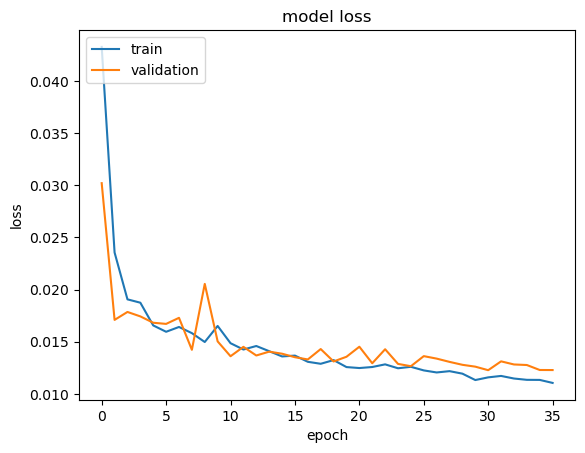

In [72]:
#plot training
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


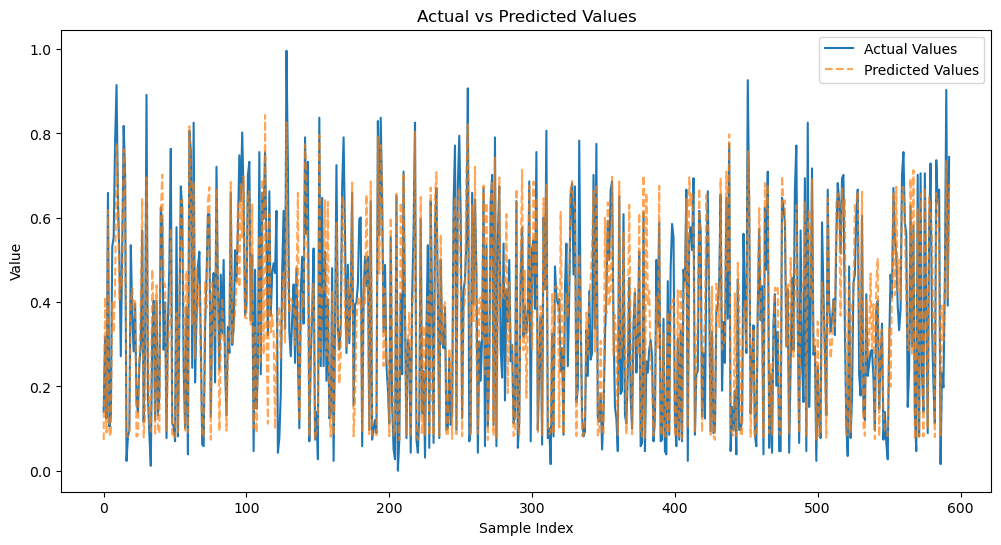

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_pred = model2.predict(X_test)

# Plot the actual vs predicted values as overlapping lines
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values', alpha=1)
plt.plot(y_pred, label='Predicted Values',linestyle='--', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [74]:
#RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RNN, Dense, Dropout, LayerNormalization, LeakyReLU, Input
from tensorflow.keras.layers import SimpleRNNCell

model3 = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  
    RNN(SimpleRNNCell(128), return_sequences=True),
    LeakyReLU(alpha=0.01),  
    Dropout(0.3),
    RNN(SimpleRNNCell(128), return_sequences=True),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    RNN(SimpleRNNCell(64)),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    Dense(64),
    LeakyReLU(alpha= 0.01),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1)  
])

model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [75]:
history3 = model3.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
)

loss, mae = model3.evaluate(X_test, y_test, verbose=1)
print(f"RNN Validation Loss: {loss}")
print(f"RNN Validation MAE: {mae}")

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0898 - mae: 0.2435 - val_loss: 0.0642 - val_mae: 0.2050 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0550 - mae: 0.1979 - val_loss: 0.0503 - val_mae: 0.1770 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0418 - mae: 0.1668 - val_loss: 0.0301 - val_mae: 0.1462 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0340 - mae: 0.1482 - val_loss: 0.0221 - val_mae: 0.1132 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0276 - mae: 0.1302 - val_loss: 0.0213 - val_mae: 0.1122 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0242 - mae: 0.1223 - val_loss: 0.0196 - val_mae: 0.1050 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0212 - mae: 0.1119 - val_loss: 0.0193 - val_mae: 0.1063 - learning_rate: 0.0010
Epoch 8/50
75/75 ━━━

In [76]:
#r2 score
y_pred = model3.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
R^2 Score: 0.7221


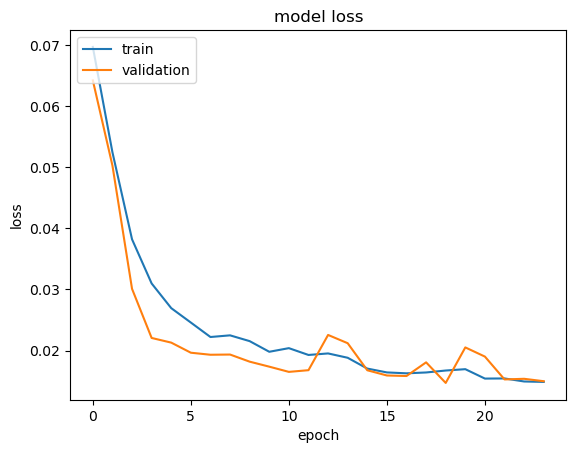

In [78]:
#plot training
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


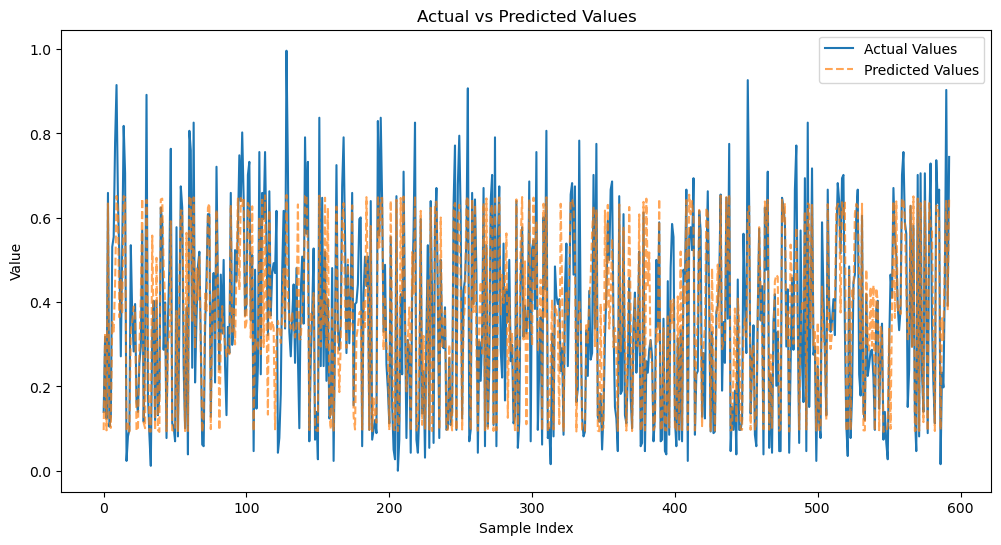

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_pred = model3.predict(X_test)

# Plot the actual vs predicted values as overlapping lines
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values', alpha=1)
plt.plot(y_pred, label='Predicted Values',linestyle='--', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
#KNNRouteOptimizer. This code is included in Classes also 
import heapq
from sklearn.neighbors import NearestNeighbors 

class KNNRouteOptimizer:
    def __init__(self, graph, G, k=5):
        """
        Initialize the KNN route optimizer with a graph and spatial representation.
        :param graph: The adjacency list containing edge attributes like 'length' or 'travel_time_seconds'.
        :param G: The original graph (osmnx format) for node coordinates.
        :param k: Number of neighbors to consider for KNN.
        """
        self.graph = graph
        self.G = G
        self.k = k
        self.node_coords = self._get_node_coordinates()
        self.knn_model = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(self.node_coords)

    def _get_node_coordinates(self):
        """
        Extract node coordinates from the graph for KNN fitting.
        :return: List of [x, y] coordinates for each node.
        """
        return [[self.G.nodes[node]['x'], self.G.nodes[node]['y']] for node in self.G.nodes]

    def knn_route(self, start, goal, metric='length'):
        """
        Find a route using KNN to explore nearest neighbors at each step.
        :param start: Starting node ID.
        :param goal: Goal node ID.
        :param metric: Edge attribute to minimize (e.g., 'length' or 'travel_time_seconds').
        :return: Path as a list of nodes and the total cost.
        """
        current_node = start
        visited = set()
        path = [current_node]
        total_cost = 0
        
        while current_node != goal:
            # Mark the current node as visited
            visited.add(current_node)

            # Get the coordinates of the current node
            current_coords = [[self.G.nodes[current_node]['x'], self.G.nodes[current_node]['y']]]

            # Find the K nearest neighbors
            distances, indices = self.knn_model.kneighbors(current_coords)
            neighbors = [list(self.G.nodes)[i] for i in indices[0]]  # Map indices to node IDs

            # Select the best neighbor not yet visited
            best_neighbor = None
            min_cost = float('inf')
            for neighbor in neighbors:
                if neighbor in visited:
                    continue  # Skip visited nodes
                if neighbor in self.graph[current_node]:
                    cost = self.graph[current_node][neighbor].get(metric, float('inf'))
                    if cost < min_cost:
                        min_cost = cost
                        best_neighbor = neighbor

            if best_neighbor is None:
                print("No valid path found!")
                return None, float('inf')

            # Update path and cost
            path.append(best_neighbor)
            total_cost += min_cost
            current_node = best_neighbor
        return path, total_cost